# Experiment 3.3

### Notice: HT means HR (Hit rate), also in other notebooks

In [1]:
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

2024-05-02 17:20:21.281977: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 17:20:21.282072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 17:20:21.414590: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
SEED = 1
np.random.seed(SEED)
tf.random.set_seed(SEED)

#### Check if GPU is available or not

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(e)
else:
    print("GPU is not available, using CPU instead.")

Using GPU: /physical_device:GPU:0


------

# **Global model**
### A model that is trained on data or purchase sequences of all users who have purchased at least 4 products

#### Loading a file with preprocessed purchase sequences of users with at least 3 purchased products

In [4]:
with open('/kaggle/input/users-sequences/users_sequences.json', 'r') as file:
    users_sequences = json.load(file)

print('Number of users/sequences in total:', len(users_sequences))

Number of users/sequences in total: 601263


#### Filtering sequences in which at least min_num_of_products_in_sequence of products were purchased, i.e. users who purchased at least min_num_of_products_in_sequence of products

In [5]:
min_num_of_products_in_sequence = 4
filtered_users_sequences = {}

for key, value in users_sequences.items():
    if len(value) >= min_num_of_products_in_sequence:
        filtered_users_sequences[key] = value

print('Number of users/sequences after filtering:', len(filtered_users_sequences))

Number of users/sequences after filtering: 372436


#### Creating sequences of length sequence_length and splitting the sequences into train, validation and test datasets, so that the last sequence is selected into the test dataset, the penultimate sequence is selected into the validation dataset and all previous ones are selected into the train dataset. Padding with a value of 0 is applied to keep the sequence length equal to sequence_length

In [6]:
sequence_length = 30

def generate_and_split_sequences(data):
    train_sequences = []
    validation_sequences = []
    test_sequences = []
    train_targets = []
    validation_targets = []
    test_targets = []
    train_user_ids = []
    validation_user_ids = []
    test_user_ids = []

    for user_id, products in data.items():
        n = len(products)
        if n < 2:
            continue

        sequences = []
        for i in range(1, n):
            current_seq = products[:i]
            if len(current_seq) < sequence_length:
                padded_seq = [0] * (sequence_length - len(current_seq)) + current_seq
                sequences.append(padded_seq)
            else:
                sequences.append(current_seq[-sequence_length:])

        targets = products[1:]

        if len(sequences) >= 2:
            train_sequences.extend(sequences[:-2])
            train_targets.extend(targets[:-2])
            train_user_ids.extend([user_id] * (len(sequences) - 2))

            validation_sequences.append(sequences[-2])
            validation_targets.append(targets[-2])
            validation_user_ids.append(user_id)

            test_sequences.append(sequences[-1])
            test_targets.append(targets[-1])
            test_user_ids.append(user_id)
        elif len(sequences) == 1:
            test_sequences.append(sequences[0])
            test_targets.append(targets[0])
            test_user_ids.append(user_id)

    return {
        'train': (train_sequences, train_targets, train_user_ids),
        'validation': (validation_sequences, validation_targets, validation_user_ids),
        'test': (test_sequences, test_targets, test_user_ids)
    }

datasets = generate_and_split_sequences(filtered_users_sequences)

#### Assigning obtained datasets to a clearer form

In [7]:
X_train = datasets['train'][0]
y_train = datasets['train'][1]

X_val = datasets['validation'][0]
y_val = datasets['validation'][1]

X_test = datasets['test'][0]
y_test = datasets['test'][1]

print("An example of what sequences and targets look like:\n\nSequences:\n", X_train[-10:])
print("\nTargets:\n", y_train[-10:])

An example of what sequences and targets look like:

Sequences:
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12441], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12441, 47820], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12441, 47820, 114530], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12441, 47820, 114530, 86657], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12441, 47820, 114530, 86657, 39579], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11424], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11424, 5089], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11424, 5089, 108533], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11424, 5089, 108533, 108535], [0,

In [8]:
print("Number of train sequences:", len(X_train))
print("Number of validation sequences:", len(X_val))
print("Number of test sequences:", len(X_test))

print("\nNumber of train targets:", len(y_train))
print("Number of validation targets:", len(y_val))
print("Number of test targets:", len(y_test))

Number of train sequences: 1609472
Number of validation sequences: 372436
Number of test sequences: 372436

Number of train targets: 1609472
Number of validation targets: 372436
Number of test targets: 372436


#### Preprocessing datasets for faster processing

In [9]:
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

-------

### Defining metrics

#### Weighted F1-score (at k=1)

In [10]:
def f1_score(y_true, y_pred):
    y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes=max_product_id)
    y_pred = K.one_hot(K.argmax(y_pred, axis=-1), num_classes=max_product_id)

    true_positives = K.sum(y_true * y_pred, axis=0)
    possible_positives = K.sum(y_true, axis=0)
    predicted_positives = K.sum(y_pred, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### F1@k

In [11]:
def f1_score_at_k(y_true, y_pred, k=5):
    num_classes = y_pred.shape[-1]

    y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)
    _, topk_indices = tf.nn.top_k(y_pred, k=k, sorted=True)
    y_pred_topk = tf.reduce_sum(K.one_hot(K.cast(topk_indices, 'int32'), num_classes=num_classes), axis=1)

    true_positives = K.sum(y_true_one_hot * y_pred_topk, axis=0)
    possible_positives = K.sum(y_true_one_hot, axis=0)
    predicted_positives = K.sum(y_pred_topk, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### HR@k

In [12]:
def hit_rate_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    top_k_mask = tf.reduce_any(tf.equal(top_k_indices, y_true), axis=-1)
    hit_rate = tf.reduce_mean(tf.cast(top_k_mask, tf.float32))

    return hit_rate

#### NDCG@k

In [13]:
def ndcg_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    relevance = tf.cast(tf.equal(top_k_indices, y_true), tf.float32)
    positions = tf.cast(tf.range(1, k + 1), tf.float32)

    dcg = tf.reduce_sum(relevance / tf.math.log(positions + 1), axis=1)
    ideal_dcg = tf.reduce_sum(1 / tf.math.log(positions + 1), axis=0)

    ndcg = tf.reduce_mean(dcg / ideal_dcg)

    return ndcg

#### Getting the highest product ID value for input_dim in Embedding layers

In [14]:
max_product_id = float('-inf')

for user, sequences in filtered_users_sequences.items():
    current_max = max(sequences)
    if current_max > max_product_id:
        max_product_id = current_max

max_product_id

144605

--------

In [15]:
def evaluate_model(model, test_dataset):
    metrics = {f'F1@{k}': [] for k in [3, 5, 10, 20]}
    metrics.update({f'HR@{k}': [] for k in [3, 5, 10, 20]})
    metrics.update({f'NDCG@{k}': [] for k in [3, 5, 10, 20]})

    progress_bar = tqdm(test_dataset, desc='Evaluating', unit='batch')

    for x_batch, y_batch in progress_bar:
        y_pred = model(x_batch)

        for k in [3, 5, 10, 20]:
            metrics[f'F1@{k}'].append(f1_score_at_k(y_batch, y_pred, k).numpy())
            metrics[f'HR@{k}'].append(hit_rate_at_k(y_batch, y_pred, k).numpy())
            metrics[f'NDCG@{k}'].append(ndcg_at_k(y_batch, y_pred, k).numpy())

    for key in metrics:
        metrics[key] = np.mean(metrics[key])

    return metrics

-------

# Bidirectional-LSTM

#### Model definition

In [16]:
model_global = Sequential()
model_global.add(Embedding(input_dim=max_product_id, output_dim=70, mask_zero=True))
model_global.add(Bidirectional(LSTM(128, activation='relu')))
model_global.add(BatchNormalization())
model_global.add(Dropout(0.2))
model_global.add(Dense(128, activation='relu'))
model_global.add(BatchNormalization())
model_global.add(Dropout(0.2))
model_global.add(Dense(max_product_id, activation='softmax'))

model_global.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

#### Model training

In [17]:
history_model_global = model_global.fit(
    train_dataset,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
    6/12574 ━━━━━━━━━━━━━━━━━━━━ 5:12 25ms/step - accuracy: 0.0071 - f1_score: 0.0067 - f1_score_at_k: 0.0103 - hit_rate_at_k: 0.0144 - loss: 11.8790 - ndcg_at_k: 0.0039                      

I0000 00:00:1714670676.160606     132 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12574/12574 ━━━━━━━━━━━━━━━━━━━━ 307s 23ms/step - accuracy: 0.0920 - f1_score: 0.0792 - f1_score_at_k: 0.0773 - hit_rate_at_k: 0.1158 - loss: 9.1444 - ndcg_at_k: 0.0355 - val_accuracy: 0.1146 - val_f1_score: 0.1050 - val_f1_score_at_k: 0.1052 - val_hit_rate_at_k: 0.1353 - val_loss: 8.5860 - val_ndcg_at_k: 0.0425
Epoch 2/25
    7/12574 ━━━━━━━━━━━━━━━━━━━━ 4:34 22ms/step - accuracy: 0.1009 - f1_score: 0.0889 - f1_score_at_k: 0.1013 - hit_rate_at_k: 0.1413 - loss: 8.1560 - ndcg_at_k: 0.0415

W0000 00:00:1714670970.676797     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714670970.678195     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12574/12574 ━━━━━━━━━━━━━━━━━━━━ 294s 23ms/step - accuracy: 0.1210 - f1_score: 0.1097 - f1_score_at_k: 0.1150 - hit_rate_at_k: 0.1521 - loss: 8.1141 - ndcg_at_k: 0.0466 - val_accuracy: 0.1217 - val_f1_score: 0.1125 - val_f1_score_at_k: 0.1153 - val_hit_rate_at_k: 0.1457 - val_loss: 8.5000 - val_ndcg_at_k: 0.0455
Epoch 3/25
12574/12574 ━━━━━━━━━━━━━━━━━━━━ 293s 23ms/step - accuracy: 0.1277 - f1_score: 0.1167 - f1_score_at_k: 0.1255 - hit_rate_at_k: 0.1630 - loss: 7.8985 - ndcg_at_k: 0.0496 - val_accuracy: 0.1240 - val_f1_score: 0.1148 - val_f1_score_at_k: 0.1201 - val_hit_rate_at_k: 0.1504 - val_loss: 8.4586 - val_ndcg_at_k: 0.0467
Epoch 4/25
12574/12574 ━━━━━━━━━━━━━━━━━━━━ 293s 23ms/step - accuracy: 0.1320 - f1_score: 0.1215 - f1_score_at_k: 0.1333 - hit_rate_at_k: 0.1707 - loss: 7.7514 - ndcg_at_k: 0.0517 - val_accuracy: 0.1269 - val_f1_score: 0.1179 - val_f1_score_at_k: 0.1231 - val_hit_rate_at_k: 0.1529 - val_loss: 8.4648 - val_ndcg_at_k: 0.0476
Epoch 5/25
12574/12574 ━━━━━━━━━━━━━

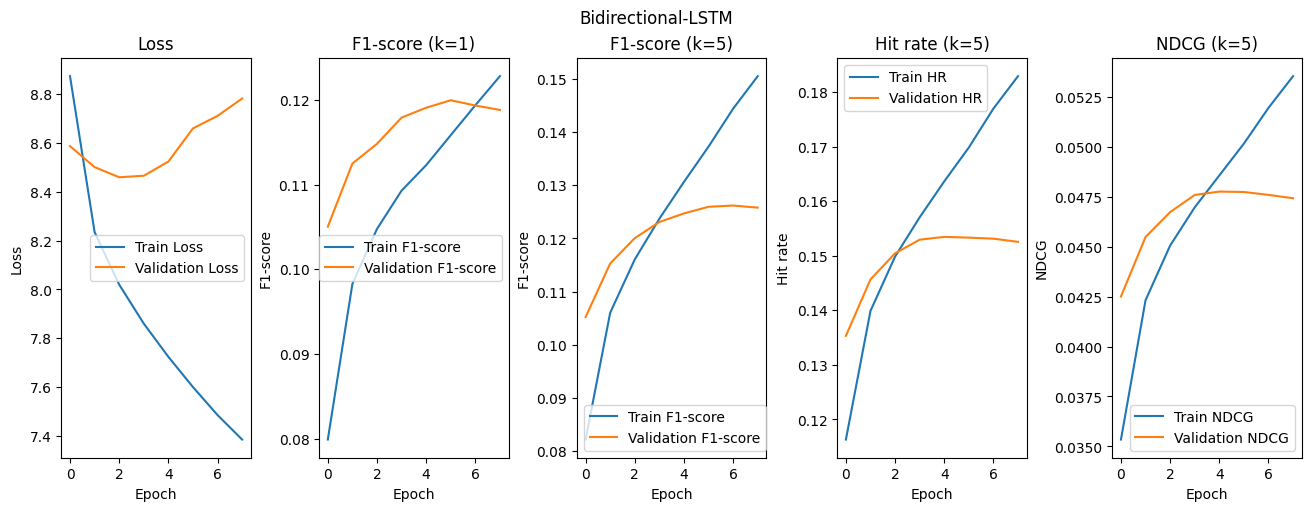

In [18]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_global.history['loss'], label='Train Loss')
ax1.plot(history_model_global.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_global.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_global.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_global.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_global.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_global.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_global.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_global.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_global.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Bidirectional-LSTM')
plt.show()

In [19]:
model_global_test_loss, model_global_test_accuracy, model_global_test_f1_score_k_1, model_global_test_f1_score_k_5, model_global_test_hr, model_global_test_ndcg = model_global.evaluate(test_dataset)

print("Test loss:", round(model_global_test_loss, 4))
print("Test accuracy:", round(model_global_test_accuracy, 4))
print("Test F1@1:", round(model_global_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_global_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_global_test_hr, 4))
print("Test NDCG@5:", round(model_global_test_ndcg, 4))

2910/2910 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.1041 - f1_score: 0.0993 - f1_score_at_k: 0.1056 - hit_rate_at_k: 0.1248 - loss: nan - ndcg_at_k: 0.0390
Test loss: nan
Test accuracy: 0.0946
Test F1@1: 0.0903
Test F1@5: 0.0975
Test HR@5: 0.1142
Test NDCG@5: 0.0355


In [20]:
metrics_results_model_global = evaluate_model(model_global, test_dataset)

counter = 0
print('---------------')
for metric, value in metrics_results_model_global.items():
    print(f'{metric}: {value:.4f}')
    counter += 1
    if counter % 4 == 0:
        print('---------------')

Evaluating: 100%|██████████| 2910/2910 [14:57<00:00,  3.24batch/s]

---------------
F1@3: 0.0959
F1@5: 0.0975
F1@10: 0.0997
F1@20: 0.1004
---------------
HR@3: 0.1073
HR@5: 0.1142
HR@10: 0.1261
HR@20: 0.1423
---------------
NDCG@3: 0.0479
NDCG@5: 0.0355
NDCG@10: 0.0239
NDCG@20: 0.0160
---------------


--------

# **Personalized models for each selected user**
### Which are trained only on the data collected for the given user (as in the experiment 2.1)

In [21]:
selected_user_ids = {
    "users-1": "A11OTLEDSW8ZXD",
    "users-2": "A22CW0ZHY3NJH8",
    "users-3": "A21U4DR8M6I9QN",
    "users-4": "A3U2NAO7853MW",
    "users-5": "A100WO06OQR8BQ",
    "users-6": "A288D2R9WAJBZS",
    "users-7": "A3CG93783LP0FO",
    "users-8": "AC5GLGVJXDEFV",
    "users-9": "AQYKV5QEAO7P5",
    "users-10": "A1RT0UQRCB2765",
    "users-11": "A2RYWPOL4NN2KG",
    "users-12": "A9NXTC0HTPSDO",
    "users-13": "A26W1UX7E3AW3J",
    "users-14": "A1HE5FWLYHKPQW",
    "users-15": "A8K5I4MF6QCGJ"
}

In [22]:
test_metrics_values = {}
users_probabilities = {}
BATCH_SIZE = 32

In [23]:
with open('/kaggle/input/users-sequences/products_encoding.json', 'r') as file:
    encoding_product_ids = json.load(file)

max_product_id = max(encoding_product_ids.values())

In [24]:
def load_and_create_sequences_targets(user, user_id):
    # Loading collected sequences from users who purchased the same products as our specific user
    file_path = f"/kaggle/input/users-pred-cat/users_pred_cat/{user}.json"
    with open(file_path, "r") as file:
        users = json.load(file)
    df_users = pd.DataFrame(users)
    df_users['purchased_before_1'] = df_users['selected_products'].apply(lambda x: x[0])
    df_users['purchased_before_2'] = df_users['selected_products'].apply(lambda x: x[1])
    df_users.drop(columns=['selected_products'], inplace=True)

    # Removing sequences and targets where any of the product that users purchased is not in the
    # metadata dataset, based on the encoding_product_ids dictionary, which contains only products which are in meta dataset
    valid_product_ids = list(encoding_product_ids.keys())
    filtered_df_users = df_users[
        (df_users['productID'].isin(valid_product_ids)) &
        (df_users['purchased_before_1'].isin(valid_product_ids)) &
        (df_users['purchased_before_2'].isin(valid_product_ids))
    ]

    # Extracting the last sequence of the specific user with the target to be predicted during testing
    last_user_sequence = filtered_df_users.loc[filtered_df_users['reviewerID'] == user_id].iloc[-1].copy()
    filtered_df_users = filtered_df_users.drop(last_user_sequence.name)

    # Dropping duplicated sequences and targets
    filtered_df_users = filtered_df_users.drop_duplicates(subset=['productID', 'purchased_before_1', 'purchased_before_2'])

    # Creating encoded sequences and targets
    sequences = filtered_df_users[['purchased_before_1', 'purchased_before_2']].copy().values
    targets = filtered_df_users['productID'].copy().values

    for i, sequence in enumerate(sequences):
        sequences[i][0] = encoding_product_ids[sequence[0]]
        sequences[i][1] = encoding_product_ids[sequence[1]]

    for i, target in enumerate(targets):
        targets[i] = encoding_product_ids[target]

    print("Number of sequences:", len(sequences))
    return sequences, targets, last_user_sequence

In [25]:
def custom_stratified_split(X, y, train_size=0.8, test_size=0.1, val_size=0.1):
    unique_classes = np.unique(y)
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []

    for cls in unique_classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)

        n = len(idx)
        n_train = int(round(train_size * n))
        n_test = int(round(test_size * n))
        n_val = n - n_train - n_test

        min_size = 1
        if n_train < min_size:
            n_train = min_size
        if n_test < min_size:
            n_test = min_size
        if n_val < min_size:
            n_val = min_size

        if n_train + n_test + n_val > n:
            excess = (n_train + n_test + n_val) - n
            if n_train >= n_test and n_train >= n_val:
                n_train -= excess
            elif n_test >= n_val:
                n_test -= excess
            else:
                n_val -= excess

        train_idx = idx[:n_train]
        val_idx = idx[n_train:n_train + n_val]
        test_idx = idx[n_train + n_val:]

        X_train.extend(X[train_idx])
        y_train.extend(y[train_idx])
        X_val.extend(X[val_idx])
        y_val.extend(y[val_idx])
        X_test.extend(X[test_idx])
        y_test.extend(y[test_idx])

    return X_train, y_train, X_val, y_val, X_test, y_test

In [26]:
def preprocess_datasets(X_train, y_train, X_val, y_val, X_test, y_test):
    X_train = [array.tolist() for array in X_train]
    X_val = [array.tolist() for array in X_val]
    X_test = [array.tolist() for array in X_test]

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
    val_dataset = val_dataset.batch(BATCH_SIZE)
    test_dataset = test_dataset.batch(BATCH_SIZE)

    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

    return train_dataset, val_dataset, test_dataset

In [27]:
def create_model():
    model_personalized = Sequential()
    model_personalized.add(Embedding(input_dim=max_product_id, output_dim=50))
    model_personalized.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
    model_personalized.add(BatchNormalization())
    model_personalized.add(Dropout(0.2))
    model_personalized.add(Bidirectional(LSTM(32, activation='relu')))
    model_personalized.add(BatchNormalization())
    model_personalized.add(Dropout(0.2))
    model_personalized.add(Dense(16, activation='relu'))
    model_personalized.add(Dense(max_product_id, activation='softmax'))

    model_personalized.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
    )

    return model_personalized

#### Evalution and collection of probabilities for a later comparison of global model vs. global model + personalized models

In [28]:
def evaluate_and_get_probabilities(model_personalized, test_dataset, user, last_user_sequence):
    model_personalized_test_loss, model_personalized_test_accuracy, model_personalized_test_f1_score_k_1, model_personalized_test_f1_score_k_5, model_personalized_test_hr, model_personalized_test_ndcg = model_personalized.evaluate(test_dataset)

    test_metrics_values[f"{user}_model_test_loss"] = model_personalized_test_loss
    test_metrics_values[f"{user}_model_test_accuracy"] = round(model_personalized_test_accuracy, 4)
    test_metrics_values[f"{user}_model_test_f1_score_k_1"] = round(model_personalized_test_f1_score_k_1, 4)
    test_metrics_values[f"{user}_model_test_f1_score_k_5"] = round(model_personalized_test_f1_score_k_5, 4)
    test_metrics_values[f"{user}_model_test_hr"] = round(model_personalized_test_hr, 4)
    test_metrics_values[f"{user}_model_test_ndcg"] = round(model_personalized_test_ndcg, 4)

    users_probabilities[user] = {
        'userID': last_user_sequence[0],
        'sequence': [encoding_product_ids[last_user_sequence[2]], encoding_product_ids[last_user_sequence[3]]],
        'target': encoding_product_ids[last_user_sequence[1]]
    }

    input_data = np.array([users_probabilities[user]['sequence']])
    probabilities = model_personalized.predict(input_data)

    users_probabilities[user]['probabilities'] = probabilities

In [29]:
def train_and_evaluate_model(user, user_id):
    sequences, targets, last_user_sequence = load_and_create_sequences_targets(user, user_id)
    X_train, y_train, X_val, y_val, X_test, y_test = custom_stratified_split(sequences, targets)
    train_dataset, val_dataset, test_dataset = preprocess_datasets(X_train, y_train, X_val, y_val, X_test, y_test)
    model_personalized = create_model()

    print("Model training started...")
    model_personalized.fit(
        train_dataset,
        epochs=50,
        batch_size=BATCH_SIZE,
        validation_data=val_dataset,
        verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
    )
    print("Model training finished")

    print("Model evaluation on test dataset...")
    evaluate_and_get_probabilities(model_personalized, test_dataset, user, last_user_sequence)

In [30]:
for user, user_id in selected_user_ids.items():
    print(f"Training model of {user}, who has ID {user_id}")
    train_and_evaluate_model(user, user_id)

    print("Result metrics on the test dataset:")
    print("Test loss:", round(test_metrics_values[f"{user}_model_test_loss"], 4))
    print("Test accuracy:", round(test_metrics_values[f"{user}_model_test_accuracy"], 4))
    print("Test F1@1:", round(test_metrics_values[f"{user}_model_test_f1_score_k_1"], 4))
    print("Test F1@5:", round(test_metrics_values[f"{user}_model_test_f1_score_k_5"], 4))
    print("Test HR@5:", round(test_metrics_values[f"{user}_model_test_hr"], 4))
    print("Test NDCG@5:", round(test_metrics_values[f"{user}_model_test_ndcg"], 4))
    print("--------------------------------------")

Training model of users-1, who has ID A11OTLEDSW8ZXD
Number of sequences: 74916
Model training started...
Model training finished
Model evaluation on test dataset...
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.0374 - f1_score: 0.0463 - f1_score_at_k: 0.0800 - hit_rate_at_k: 0.0626 - loss: 6.2505 - ndcg_at_k: 0.0171   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Result metrics on the test dataset:
Test loss: 5.9663
Test accuracy: 0.0633
Test F1@1: 0.0829
Test F1@5: 0.1564
Test HR@5: 0.1236
Test NDCG@5: 0.0318
--------------------------------------
Training model of users-2, who has ID A22CW0ZHY3NJH8
Number of sequences: 54279
Model training started...
Model training finished
Model evaluation on test dataset...
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.0921 - f1_score: 0.1144 - f1_score_at_k: 0.2337 - hit_rate_at_k: 0.1727 - loss: 5.1665 - ndcg_at_k: 0.0446       
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Result metrics on the test dataset:
Test loss: 4.9329
Test accuracy: 0.

-------

# Comparison of global model predictions vs. global model predictions combined with a personalized model for each user predictions and evaluation using metrics

## Global model predictions and evaluation

In [31]:
with open('/kaggle/input/users-sequences/users_encoding.json', 'r') as file:
    encoding_user_ids = json.load(file)

counter = 0
for key, value in encoding_user_ids.items():
    print(key, ":", value)
    counter += 1
    if counter == 10:
        break

A0001528BGUBOEVR6T5U : 1
A0008110GFYR1UGK6HPQ : 2
A0010158IH80M4C0LOJ1 : 3
A001170867ZBE9FORRQL : 4
A0015332H21AK8WZ0ZCS : 5
A0015810ZQUOLSYY4TM6 : 6
A00181966XZUX7KEGYLH : 7
A0020060B0WZJ5TLXZ9Q : 8
A0024320PFCKHZ0HWVFN : 9
A0031168R52K0NLGCDVX : 10


In [32]:
selected_user_ids_encoded = {user: str(encoding_user_ids[userid]) for user, userid in selected_user_ids.items()}
selected_user_ids_list = list(selected_user_ids_encoded.values())

test_sequences, test_targets, test_user_ids = datasets['test']
test_sequences = np.array(test_sequences)
test_targets = np.array(test_targets)
test_user_ids = np.array(test_user_ids)
indices = np.where(np.isin(test_user_ids, selected_user_ids_list))[0]

selected_user_sequences = test_sequences[indices]
selected_user_targets = test_targets[indices]

In [33]:
probabilities_model_global = model_global.predict(selected_user_sequences)
k_values = [3, 5, 10, 20, 50, 100, 200, 300, 400, 500]

for k in k_values:
    f1_score = f1_score_at_k(selected_user_targets, probabilities_model_global, k=k).numpy()
    print(f"F1@{k}: {f1_score}")

    hit_rate = hit_rate_at_k(selected_user_targets, probabilities_model_global, k=k).numpy()
    print(f"HT@{k}: {hit_rate}")

    ndcg = ndcg_at_k(selected_user_targets, probabilities_model_global, k=k).numpy()
    print(f"NDCG@{k}: {ndcg}")

    print("-------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
F1@3: 0.0
HT@3: 0.0
NDCG@3: 0.0
-------------
F1@5: 0.0
HT@5: 0.0
NDCG@5: 0.0
-------------
F1@10: 0.0
HT@10: 0.0
NDCG@10: 0.0
-------------
F1@20: 0.06666665524244308
HT@20: 0.06666667014360428
NDCG@20: 0.002487116726115346
-------------
F1@50: 0.19999995827674866
HT@50: 0.20000000298023224
NDCG@50: 0.0034578752238303423
-------------
F1@100: 0.19999995827674866
HT@100: 0.20000000298023224
NDCG@100: 0.0021299703512340784
-------------
F1@200: 0.166666641831398
HT@200: 0.20000000298023224
NDCG@200: 0.001280908240005374
-------------
F1@300: 0.14444443583488464
HT@300: 0.20000000298023224
NDCG@300: 0.0009413216612301767
-------------
F1@400: 0.12222221493721008
HT@400: 0.20000000298023224
NDCG@400: 0.0007532040472142398
-------------
F1@500: 0.1155555471777916
HT@500: 0.20000000298023224
NDCG@500: 0.0006320971297100186
-------------


-------

## Combining predictions - Global model predictions combined with a personalized models predictions

In [34]:
all_user_probabilities = [user_info['probabilities'] for user_info in users_probabilities.values()]
probabilities_models_personalized = np.concatenate(all_user_probabilities, axis=0)

In [35]:
combined_probabilities = 0.5 * probabilities_model_global + 0.5 * probabilities_models_personalized

In [36]:
k_values = [3, 5, 10, 20, 50, 100, 200, 300, 400, 500]

for k in k_values:
    f1_score = f1_score_at_k(selected_user_targets, combined_probabilities, k=k).numpy()
    print(f"F1@{k}: {f1_score}")

    hit_rate = hit_rate_at_k(selected_user_targets, combined_probabilities, k=k).numpy()
    print(f"HT@{k}: {hit_rate}")

    ndcg = ndcg_at_k(selected_user_targets, combined_probabilities, k=k).numpy()
    print(f"NDCG@{k}: {ndcg}")

    print("-------------")

F1@3: 0.04444444179534912
HT@3: 0.06666667014360428
NDCG@3: 0.015642622485756874
-------------
F1@5: 0.04444444179534912
HT@5: 0.06666667014360428
NDCG@5: 0.011305340565741062
-------------
F1@10: 0.04444444179534912
HT@10: 0.06666667014360428
NDCG@10: 0.007336392067372799
-------------
F1@20: 0.08888888359069824
HT@20: 0.13333334028720856
NDCG@20: 0.006963834166526794
-------------
F1@50: 0.08888888359069824
HT@50: 0.13333334028720856
NDCG@50: 0.003801231039687991
-------------
F1@100: 0.15555554628372192
HT@100: 0.20000000298023224
NDCG@100: 0.0028873225674033165
-------------
F1@200: 0.24888885021209717
HT@200: 0.3333333432674408
NDCG@200: 0.0022740093991160393
-------------
F1@300: 0.231111079454422
HT@300: 0.3333333432674408
NDCG@300: 0.0016711376374587417
-------------
F1@400: 0.231111079454422
HT@400: 0.3333333432674408
NDCG@400: 0.0013371704844757915
-------------
F1@500: 0.21999996900558472
HT@500: 0.3333333432674408
NDCG@500: 0.001122168148867786
-------------


------

# Recommendations

In [38]:
recommendations = {}
k_values = [3, 5, 10, 20]

for k in k_values:
    for i, (user, user_id) in enumerate(selected_user_ids.items()):
        _, combined_predictions = tf.nn.top_k(combined_probabilities, k=k)
        recommendations[f"{user}_{user_id}_top_{k}"] = combined_predictions.numpy()[i]
        print(f"Top {k} recommended products for {user} who has ID {user_id}:", combined_predictions.numpy()[i])
    print("------------------------------------------------------------------------------------------------------------------------")

Top 3 recommended products for users-1 who has ID A11OTLEDSW8ZXD: [129989 115793 110656]
Top 3 recommended products for users-2 who has ID A22CW0ZHY3NJH8: [111124 126080    887]
Top 3 recommended products for users-3 who has ID A21U4DR8M6I9QN: [139193 117245 142330]
Top 3 recommended products for users-4 who has ID A3U2NAO7853MW: [57739 52610 79574]
Top 3 recommended products for users-5 who has ID A100WO06OQR8BQ: [143682 143683  79574]
Top 3 recommended products for users-6 who has ID A288D2R9WAJBZS: [71385 15738 70180]
Top 3 recommended products for users-7 who has ID A3CG93783LP0FO: [ 68520 135429 131369]
Top 3 recommended products for users-8 who has ID AC5GLGVJXDEFV: [13889  8788 37031]
Top 3 recommended products for users-9 who has ID AQYKV5QEAO7P5: [19450 21102 98882]
Top 3 recommended products for users-10 who has ID A1RT0UQRCB2765: [45404 68072  7052]
Top 3 recommended products for users-11 who has ID A2RYWPOL4NN2KG: [110521  98988 111684]
Top 3 recommended products for users-

In [43]:
for user, user_info in users_probabilities.items():
    user_id = user_info['userID']
    target = user_info['target']
    
    found_in = None
    user_seq = user.split('-')[1]

    for n in [3, 5, 10, 20]:
        rec_key = f'users-{user_seq}_{user_id}_top_{n}'
        if rec_key in recommendations:
            if target in recommendations[rec_key]:
                found_in = n
                break

    if found_in:
        print(f"The target for {user} was predicted in top{found_in} recommendations")
    else:
        print(f"The target for {user} was not found in any of the topN recommendations")

The target for users-1 was not found in any of the topN recommendations
The target for users-2 was not found in any of the topN recommendations
The target for users-3 was not found in any of the topN recommendations
The target for users-4 was not found in any of the topN recommendations
The target for users-5 was predicted in top3 recommendations
The target for users-6 was not found in any of the topN recommendations
The target for users-7 was predicted in top20 recommendations
The target for users-8 was predicted in top20 recommendations
The target for users-9 was predicted in top20 recommendations
The target for users-10 was not found in any of the topN recommendations
The target for users-11 was predicted in top10 recommendations
The target for users-12 was predicted in top3 recommendations
The target for users-13 was not found in any of the topN recommendations
The target for users-14 was not found in any of the topN recommendations
The target for users-15 was not found in any of t